# Evaluate performance & limitations of taxonomy operationalisation

**How is this script structured?**

0. Setup
1. Assess classifier performance and prediction uncertainty
    - What is the performance of each classifier in each category on out-of-sample data? 
    - What is the uncertainty associated with each prediction? 
    - For each model and each class, what is the association between the proportion of the training data, and the performance of the model in that class?
2. Evaluate key assumptions made during fine-tuning
    - that the model generalises
    - the labels are correct
    - confidence scores reflect accuracy
3. Consider the implications of these assumptions for inference in social scientific applications.

# 0. Setup

In [1]:
##############################################
# Code implemented on:
# - Python Version: 3.11.11
# - Last modified: 08.08.2025
##############################################

################### Imports #################
import os
import sys
import krippendorff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


################### Paths #################
PROJECT_ROOT = "/Users/carolinewagner/Desktop/Local/MY498-capstone-main"

# Where should the outputs be saved to?
results_output_path = os.path.join(
    PROJECT_ROOT,
    "03_outputs",
    "01_taxonomies_of_interrogatives",
    "01_analyses_results"
)

# Where are the heper functions to be sourced? 
helper_path = os.path.join(
    PROJECT_ROOT,
    "02_code",
    "01_helper-functions"
)

# Where is the dataset with the final full PRISM dataset with BERT classifications and monte-carlo uncertainty estimations?
classified_path = os.path.join(PROJECT_ROOT, "01_data", 
                               "07_final_classified_data", 
                               "final_data_with_uncertainty.jsonl")


# Where is the folder with the labelled data files?
labelled_data_dir = os.path.join(
    PROJECT_ROOT,
    "01_data",
    "02_data-labelling",
    "06_labelled_csv_files"
)

# Where is the dataset with the gold-standard rows saved? 
gold_path = os.path.join(PROJECT_ROOT, "01_data", 
                         "06_design-based_supervised-learning", 
                         "labelled_gold_standard.csv")

# Where is the dataset used for training with labels for all the classifiers saved? 
train_path = os.path.join(PROJECT_ROOT, "01_data", 
                          "03_BERT_fine-tuning", 
                          "train_main_labeller.csv")

# Where should the figures be saved to? 
figures_path = os.path.join(PROJECT_ROOT, "03_outputs", 
                          "01_taxonomies_of_interrogatives", 
                          "02_figures")

# Where should appendices be saved to? 
appendices_path = os.path.join(PROJECT_ROOT, "03_outputs", 
                          "04_appendices")

# Where are the results from the second round of labelling saved?
labelled_data_round_two = os.path.join(
    PROJECT_ROOT,
    "01_data",
    "02_data-labelling",
    "07_round_two_labelling"
)

################### Load data #################
# (1) Load the final full PRISM dataset with BERT classifications and monte-carlo uncertainty estimations. 
classified_df = pd.read_json(classified_path, lines=True)

# (2) Load the different datasets for inter-coder reliabilities. 
# (a) Define file names
file1 = "26.04_labelled_one_percent_prompts_labeller_1.csv"
file2 = "26.04_labelled_one_percent_prompts_labeller_2.csv"
file3 = "27.04_labelled_sampled_user_prompts_main_labeller.csv"
labeller1_round_two = "08.08_labeller_1.csv"

# (b) Load the files
labeller1_df = pd.read_csv(os.path.join(labelled_data_dir, file1))
labeller2_df = pd.read_csv(os.path.join(labelled_data_dir, file2))
main_labeller_df = pd.read_csv(os.path.join(labelled_data_dir, file3))
labeller1_round_two = pd.read_csv(os.path.join(labelled_data_round_two, labeller1_round_two))

# (3) The gold-standard dataset; these are labelled rows that were not used to train the models and
# are therefore out-of-sample. 
gold_df = pd.read_csv(gold_path)

# (4) Load training dataset
train_df = pd.read_csv(train_path)


################### Source required functions #################
sys.path.append(helper_path)
from general_python_helper import *

In [2]:
################### Quick sense check #################

# (1) Category counts
print("\nCategory counts:")
print(classified_df[[
    'M', 'why_q', 'whether_q', 'which_q', 'whathow_q', 'hobsons_c'
]].sum())

# (2) Check mutual exclusivity
classified_df['num_matched'] = classified_df[[
    'why_q', 'whether_q', 'which_q', 'whathow_q', 'hobsons_c'
]].sum(axis=1)

print("\nRows assigned to more than one category:", (classified_df['num_matched'] > 1).sum())


Category counts:
M             177
why_q         449
whether_q    2365
which_q      1428
whathow_q    2633
hobsons_c     778
dtype: int64

Rows assigned to more than one category: 0


In [3]:
##############################################
# Clean & pre-process data
##############################################

# (1) Clean and format the datasets with the annotator labels. 
# Remove the empty unnamed columns from the main labeller dataset. 
main_labeller_df = main_labeller_df.loc[:, ~main_labeller_df.columns.str.contains("^Unnamed")]

# (2) Rename columns in labelling datasets to include coder prefix (except utterance_id)
labeller1_df_renamed = labeller1_df.rename(columns=lambda col: f"labeller_one_{col}" if col != 'utterance_id' else col)
labeller2_df_renamed = labeller2_df.rename(columns=lambda col: f"labeller_two_{col}" if col != 'utterance_id' else col)
main_labeller_df_renamed = main_labeller_df.rename(columns=lambda col: f"labeller_main_{col}" if col != 'utterance_id' else col)

# (3) Merge all 3 on utterance_id
merged_df = main_labeller_df_renamed.merge(
    labeller1_df_renamed, on='utterance_id', how='inner'
).merge(
    labeller2_df_renamed, on='utterance_id', how='inner'
)

# (4) Drop duplicate user_prompt columns if identical across files
merged_df = merged_df.drop(columns=[
    col for col in merged_df.columns
    if col.startswith('labeller_one_user_prompt') or col.startswith('labeller_two_user_prompt')
])

# (5) Replace all NaN with M to match implementation of analyses throughout the rest of the project. 
# (the BERT classifiers predict Ms)
merged_df = merged_df.fillna("M")

# (6) Now, focus on the labelled data that were not used to fine tune the BERT classifiers.
classifiers = ["1A", "1B", "2A", "2B", "2C", "3A", "4A"]

# (a) Construct full label column names
label_columns = [f"label_{clf}" for clf in classifiers]

# (b) Fill NaNs in those columns only
classified_df[label_columns] = classified_df[label_columns].fillna("M")

# 1. Characterise the performance of each classifier in each category
(a) What is the performance of each classifier in each category on out-of-sample data? 

(b) What is the uncertainty associated with each prediction?

(c) For each model and each class, what is the association between the proportion of the training data, and the performance of the model in that class?

Evaluation metric = focus on weighted F1

### 1. (a) What is the performance of each classifier in each category on out-of-sample data? 
Broken down into two steps: 
1. Computes the per-class and overall performance of the fine-tuned BERT classifiers
2. Evaluate how well the combined taxonomy logic (using all classifiers) performs in assigning final interrogative categories.

In [4]:
##############################################
# Data pre-processing & implement performance evaluation
# This code computes the per-class and overall performance of the fine-tuned BERT classifiers (for appendix D)
##############################################

# (1) Define mapping between classifiers and gold label column names
classifier_map = {
    "1A": "Q1A", "1B": "Q1B",
    "2A": "Q2A", "2B": "Q2B", "2C": "Q2C",
    "3A": "Q3A", "4A": "Q4A"
}

# (2) Rename gold and BERT prediction columns
gold_df_renamed = gold_df.rename(columns={v: f"label_{k}_gold" for k, v in classifier_map.items()})
classified_df_renamed = classified_df.rename(columns={f"label_{k}": f"label_{k}_bert" for k in classifier_map})

# (3) Merge both dfs on 'utterance_id'
merged_df = pd.merge(gold_df_renamed, classified_df_renamed, on="utterance_id", how="inner")

# (4) Evaluate performance using sourced function 
overall_perf_df, category_perf_df = evaluate_classifiers(merged_df, classifier_map)

# (5) Export to CSV to format in R
# Ensure the output directory exists
os.makedirs(results_output_path, exist_ok=True)

# (6) Build full file paths
overall_csv_path = os.path.join(results_output_path, "overall_model_performance.csv")
category_csv_path = os.path.join(results_output_path, "category_level_performance.csv")

# (7) Export dfs
overall_perf_df.to_csv(overall_csv_path, index=False)
category_perf_df.to_csv(category_csv_path, index=False)

In [5]:
##############################################
# Collect summary stats for report
##############################################

# (1) Summary stats for accuracy
min_accuracy = overall_perf_df["accuracy"].min()
max_accuracy = overall_perf_df["accuracy"].max()
mean_accuracy = overall_perf_df["accuracy"].mean()
std_accuracy = overall_perf_df["accuracy"].std()

# (2) Summary stats for weighted F1
min_f1 = overall_perf_df["weighted_f1"].min()
max_f1 = overall_perf_df["weighted_f1"].max()
mean_f1 = overall_perf_df["weighted_f1"].mean()
std_f1 = overall_perf_df["weighted_f1"].std()

# (3) Print results
print("Overall Accuracy (per classifier):")
print(f"Min:  {min_accuracy:.4f}")
print(f"Max:  {max_accuracy:.4f}")
print(f"Mean: {mean_accuracy:.4f}")
print(f"SD:   {std_accuracy:.4f}\n")

print("Overall Weighted F1 Score (per classifier):")
print(f"Min:  {min_f1:.4f}")
print(f"Max:  {max_f1:.4f}")
print(f"Mean: {mean_f1:.4f}")
print(f"SD:   {std_f1:.4f}")

Overall Accuracy (per classifier):
Min:  0.8600
Max:  0.9800
Mean: 0.9410
SD:   0.0451

Overall Weighted F1 Score (per classifier):
Min:  0.8499
Max:  0.9792
Mean: 0.9373
SD:   0.0498


In [6]:
##############################################
# Evaluate how well the combined taxonomy logic (using all classifiers)
#  performs in assigning final interrogative categories.
##############################################

# Evalaute the final interrogative category assignment performance on out-of-sample data 
# This means that on the 300 PRISM user prompts that were not used for fine-tuning (now in merged_df), I need to get:

# (0) List of classifier columns
classifier_keys = ["1A", "1B", "2A", "2B", "2C", "3A", "4A"]

# (1) The final interrogative category assignment for the dataset labelled by humans
# All the BERT classification outputs are saved under the colname format: label_2A_bert

# (a) Create temp columns for gold
temp_gold_cols = {f"label_{k}_gold": f"label_{k}" for k in classifier_keys}
gold_input_df = merged_df.rename(columns=temp_gold_cols)

# (b) Apply taxonomy function to gold-labelled data
gold_question_types = gold_input_df.apply(assign_question_types_taxonomy, axis=1)
gold_question_types = gold_question_types.add_suffix("_gold")  # Add suffix to output columns

# (2) The final interrogative cartegory assignment for the dataset labelled by the fine-tuned BERTs
# All the human classification outputs are saved under the colname format: label_2A_gold

# (a) Create temp columns for BERT
temp_bert_cols = {f"label_{k}_bert": f"label_{k}" for k in classifier_keys}
bert_input_df = merged_df.rename(columns=temp_bert_cols)

# (b) Apply taxonomy function to BERT-predicted data
bert_question_types = bert_input_df.apply(assign_question_types_taxonomy, axis=1)
bert_question_types = bert_question_types.add_suffix("_bert")  # Add suffix to output columns

# (3) Merge both into original merged_df
merged_df = pd.concat([merged_df, gold_question_types, bert_question_types], axis=1)

# (4) Compute accuracies and F1 scores per interrogative category 
question_types = ['why_q', 'whether_q', 'which_q', 'whathow_q', 'hobsons_c', 'M']
perf_df = evaluate_question_types(merged_df, question_types)

# (5) Collect stats to be reported in manuscript
# (a) Compute min and max values across categories
min_accuracy = perf_df["accuracy"].min()
max_accuracy = perf_df["accuracy"].max()

min_f1 = perf_df["f1"].min()
max_f1 = perf_df["f1"].max()

# (b) Compute standard deviations (excluding the MEAN row itself)
accuracy_sd = perf_df["accuracy"].std()
f1_sd = perf_df["f1"].std()

# (6) Compute mean performance
mean_row = {
    "category": "MEAN",
    "accuracy": perf_df["accuracy"].mean(),
    "precision": perf_df["precision"].mean(),
    "recall": perf_df["recall"].mean(),
    "f1": perf_df["f1"].mean(),
    "support": perf_df["support"].sum() 
}

# (7) Append to df
perf_df = pd.concat([perf_df, pd.DataFrame([mean_row])], ignore_index=True)

# (8) Print full performance table and summary stats
print("Overall classifier performances per interrogative category:")
print(perf_df)

print("\nSummary statistics across categories (excluding MEAN):")
print(f"Accuracy — Min: {min_accuracy:.4f}, Max: {max_accuracy:.4f}, SD: {accuracy_sd:.4f}")
print(f"F1 Score — Min: {min_f1:.4f}, Max: {max_f1:.4f}, SD: {f1_sd:.4f}")

Overall classifier performances per interrogative category:
    category  accuracy  precision    recall        f1  support
0      why_q  0.996667   0.937500  1.000000  0.967742     15.0
1  whether_q  0.936667   0.870968  0.920455  0.895028     88.0
2    which_q  0.896667   0.836364  0.676471  0.747967     68.0
3  whathow_q  0.923333   0.857143  0.932039  0.893023    103.0
4  hobsons_c  0.996667   0.933333  1.000000  0.965517     14.0
5          M  0.993333   1.000000  0.714286  0.833333      7.0
6       MEAN  0.957222   0.905885  0.873875  0.883768    295.0

Summary statistics across categories (excluding MEAN):
Accuracy — Min: 0.8967, Max: 0.9967, SD: 0.0439
F1 Score — Min: 0.7480, Max: 0.9677, SD: 0.0836


### 1. (b) What is the uncertainty associated with each prediction? 

In [7]:
###################################################################################
# Format outputs from the monte-carlo uncertainty estimations
# #################################################################################

# (1) First, I have to unnest the findings from the dictionaries saved in the outputs. 
# This will include creating columns with the means and sds in the format mc_estimate_1AB_label_m // and mc_estimate_1AB_label_sd
# Identify all columns to unnest (those that start with 'mc_uncertainty_')
cols_to_unnest = [col for col in classified_df.columns if col.startswith("mc_uncertainty_")]

# (a) Unnest each column and replace dots in keys.
for col in cols_to_unnest:
    # (b) Apply json_normalize directly.
    unnested_df = pd.json_normalize(classified_df[col])
    
    # (c) Replace dots with underscores in new column names.
    unnested_df.columns = [f"{col}_{subcol}".replace(".", "_") for subcol in unnested_df.columns]
    
    # (d) Join unnested columns back to the original DataFrame.
    classified_df = classified_df.join(unnested_df)

# (e) Drop the original nested dictionary columns
classified_df.drop(columns=cols_to_unnest, inplace=True)

# (2) Remove two columns where there was a formatting issue
# (these are duplicated - and this is an issue that was unfortunately carried forward from the data labelling - one of the labels was saved as 'n '
# and therefore recognised as a separate category to 'n'. But this does not influence the performance of downstream analyses.
# This drops them only if they still exist (if code is run more than once)
problematic_cols = [
    'mc_uncertainty_4A_n _mean',
    'mc_uncertainty_4A_n _std'
]
existing_cols_to_drop = [col for col in problematic_cols if col in classified_df.columns]
classified_df.drop(columns=existing_cols_to_drop, inplace=True)

# (3) Implementing the sensecheck that I added while computing the monte-carlo uncertainty estimations
# to ensure that all the rows are processed properlty through the batches. 
# First, I have to check that all the columns and utterance IDs work with one another and if yes, delete the duplicated outcomes. 
utterance_id_cols = [col for col in classified_df.columns if col.startswith('mc_uncertainty_') and col.endswith('_utterance_id')]
all_consistent = (classified_df[utterance_id_cols].nunique(axis=1) == 1).all()

# Sensecheck returned that all the utterance_ids are aligned as intended, and therefore I am deleting the redundant columns. 
cols_to_drop = [col for col in classified_df.columns if col.startswith('mc_uncertainty_') and col.endswith('_utterance_id')]
classified_df.drop(columns=cols_to_drop, inplace=True)

In [8]:
###################################################################################
# Implement propagation of uncertainty estimations & evaluate final classification prediction uncertainty
# #################################################################################

# This code chunk summarises uncertainty estimates from Monte Carlo dropout simulations for each classifier-label combination 
# by calculating the mean, sd, and variance of prediction confidence scores. It also links these uncertainty 
# metrics to the proportion of training data per label, to enable an evaluation of whether training frequency is associated with model 'confidence'.

# (1) Replace all NaNs in train_df with 'M' - as Ms are predicted by the BERT models, 
# and replacing them ensures that they get processed properly. 
train_df = train_df.fillna("M")

# (2) For each fine-tuned BERT compute the proportion of training samples per label. 
train_props = {}

for col in train_df.columns:
    if col.startswith("X"):
        classifier = col[1:]  # remove 'X' prefix to get e.g. '1A'
        value_counts = train_df[col].value_counts(normalize=True)
        for label, prop in value_counts.items():
            train_props[(classifier, str(label))] = prop



# (3) Extract colnames from classified_df that contain mean and sd of MC dropout uncertainties
uncertainty_mean_cols = [col for col in classified_df.columns if col.startswith('mc_uncertainty_') and col.endswith('_mean')]
uncertainty_std_cols = [col for col in classified_df.columns if col.startswith('mc_uncertainty_') and col.endswith('_std')]

# (4) Loop through each classifier-label pair and
records = []

for mean_col in uncertainty_mean_cols:
    # (a) Extract the mean and sd of MC dropout estimations
    std_col = mean_col.replace('_mean', '_std')

    parts = mean_col.split('_')
    classifier = parts[2]# e.g. '1A', '2C'...
    label = parts[3] # e.g. 'y', 'n', 'M',... 

    # (b) get prediction means and sds across MC simulations
    pred_means = classified_df[mean_col]
    pred_stds = classified_df[std_col]

    train_prop = train_props.get((classifier, label), np.nan) 

    # (c) Build record with the information that I want
    record = {
        'classifier_name': classifier,
        'classifier_label': label,
        'train_proportion': train_prop * 100, # to get percentages
        'prediction_confidence_mean': pred_means.mean(),
        'prediction_confidence_std': pred_means.std(ddof=1), # variability across utterances
        # first square the standard deviations to get the row-wise variance and then take the mean of those variances
        'overall_prediction_confidence_variance': np.mean(pred_stds ** 2)
    }

    records.append(record)

# (5) Create final summary dataframe
mc_uncertainty_overall = pd.DataFrame(records)

# (6) Format the numbers
format_map = {
    'prediction_confidence_mean': '{:.3f}',
    'prediction_confidence_std': '{:.3f}',
    'overall_prediction_confidence_variance': '{:.4f}',
    'train_proportion': '{:.1f}'
}

for col, fmt in format_map.items():
    mc_uncertainty_overall[col] = mc_uncertainty_overall[col].map(fmt.format)

# (7) Sort and clean up labels so that they look nice in the table
mc_uncertainty_overall = mc_uncertainty_overall.sort_values(by=['classifier_name', 'classifier_label'])

label_map = {
    "y": "Yes",
    "n": "No",
    "u": "Undefined",
    "o": "Opinion",
    "0": "0",
    "1": "1",
    "2": "2",
    "3": "3",
    "M": "Not applicable"
}

mc_uncertainty_overall['classifier_label'] = mc_uncertainty_overall['classifier_label'].replace(label_map)

# (8) Export this as a csv
os.makedirs(results_output_path, exist_ok=True)
mc_uncertainty_overall.to_csv(os.path.join(results_output_path, "mc_uncertainty_overall.csv"), index=False)

# I am computing the mean variances across the entire dataset because taking the mean of the standard deviation
# would underestimate the true average variance since the standard deviation is the square root of the variance. 

In [9]:
# (9) Apply the function that classifies the 100 predictions from the monte-carlo uncertainty estimation
# into a dictionary with class counts, to facilitate the entropy calculation in the next step. 
classified_df['mc_dropout_counts'] = classified_df.apply(classify_mc_dropout, axis=1)

In [10]:
# (10) Look at all the rows that have a value of 0 for the non-matched categories. 
unmatched_df = classified_df[classified_df['num_matched_categories'] == 0]

unmatched_df

,utterance_id,interaction_id,conversation_id,user_id,conversation_type,user_prompt,score,label_1A,score_1A,label_1B,...,mc_uncertainty_1A_y_std,mc_uncertainty_4A_M_mean,mc_uncertainty_4A_M_std,mc_uncertainty_4A_n_mean,mc_uncertainty_4A_n_std,mc_uncertainty_4A_o_mean,mc_uncertainty_4A_o_std,mc_uncertainty_4A_y_mean,mc_uncertainty_4A_y_std,mc_dropout_counts
15,ut120,int1877,c15,user8,unguided,My 11weeks old son decide he doesn't want to b...,20,y,0.988110,M,...,0.003151,0.005917,0.001218,0.025237,0.009191,0.947660,0.012591,0.011711,0.002409,"{'not_matched': 91, 'whether': 9}"
39,ut317,int10952,c39,user8,controversy guided,Am I a saint. What is a saint?,97,y,0.987066,M,...,0.003235,0.003333,0.000637,0.019109,0.006292,0.003812,0.000842,0.970555,0.007263,{'not_matched': 100}
46,ut378,int13616,c46,user3,values guided,the 2024 elections are coming up soon i dont k...,88,n,0.899134,M,...,0.158286,0.005221,0.001069,0.798115,0.081630,0.008582,0.001674,0.184247,0.080644,"{'not_matched': 99, 'hobsons': 1}"
63,ut508,int19893,c63,user11,controversy guided,The government should support people who do no...,86,y,0.986045,M,...,0.003849,0.004513,0.000937,0.980424,0.003219,0.005734,0.001298,0.005558,0.001221,"{'not_matched': 76, 'whether': 24}"
163,ut1385,int2419,c164,user25,unguided,Do you ever played highrise? what do you think...,1,y,0.987761,M,...,0.003601,0.005864,0.001110,0.007125,0.001682,0.965886,0.004069,0.011783,0.001975,{'not_matched': 100}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7711,ut65851,int25216,c7720,user1381,unguided,I am doing vermicomposting in my backyard. It...,50,y,0.987755,M,...,0.003476,0.003427,0.000790,0.976727,0.004322,0.004219,0.000833,0.012947,0.003371,"{'not_matched': 94, 'whether': 6}"
7713,ut65869,int25223,c7722,user1419,values guided,"I am a Christian, should I go to Church every ...",100,n,0.876176,M,...,0.217091,0.004395,0.000917,0.978271,0.003815,0.005198,0.001320,0.008789,0.002304,{'not_matched': 100}
7784,ut66519,int25520,c7793,user1471,values guided,Different religions in different part of the w...,50,y,0.985228,M,...,0.003908,0.004872,0.001175,0.954365,0.012290,0.004098,0.000754,0.033450,0.011079,"{'whether': 31, 'not_matched': 69}"
7970,ut68094,int26213,c7979,user182,controversy guided,If I were to manufacture a slimming pill that ...,50,y,0.987257,M,...,0.003061,0.004574,0.001136,0.964119,0.008365,0.004299,0.000841,0.023490,0.007014,{'not_matched': 100}


In [14]:
###################################################################################
# Compute entropies to estimate uncertainty using MC dropout preds
# #################################################################################

# (1) Get the most commonly predicted category
classified_df['mc_final_interrogative_category'] = classified_df['mc_dropout_counts'].apply(get_mc_mode)

# (2) Calculate the entropy
classified_df['mc_entropy'] = classified_df['mc_dropout_counts'].apply(compute_mc_entropy)

# (3) Compute summary stats
entropy_summary_df = compute_entropy_summary(classified_df)

# (4) Drop the ALL row to only consider actual categories
category_entropy_means = entropy_summary_df.drop("ALL")["mean_entropy"]


################### Stats to describe entropies for final report ################################

# (5) Mean of the mean entropies
mean_of_means = category_entropy_means.mean()

# (6) Standard deviation of the mean entropies
std_of_means = category_entropy_means.std()

# (7) Identify category with lowest mean entropy
lowest_entropy_category = category_entropy_means.idxmin()

# (8) Identify category with highest mean entropy
highest_entropy_category = category_entropy_means.idxmax()

# (9) Get full row for category with lowest mean entropy
lowest_entropy_row = entropy_summary_df.loc[lowest_entropy_category]
lowest_mean_entropy = lowest_entropy_row["mean_entropy"]
lowest_std_entropy = lowest_entropy_row["std_entropy"]

# (10) Get full row for category with highest mean entropy
highest_entropy_row = entropy_summary_df.loc[highest_entropy_category]
highest_mean_entropy = highest_entropy_row["mean_entropy"]
highest_std_entropy = highest_entropy_row["std_entropy"]

# (11) Print
print(f"Mean of mean entropies: {mean_of_means:.4f}")
print(f"Standard deviation of mean entropies: {std_of_means:.4f}")

print(f"Lowest mean entropy: {lowest_mean_entropy:.4f} ± {lowest_std_entropy:.4f} ({lowest_entropy_category})")
print(f"Highest mean entropy: {highest_mean_entropy:.4f} ± {highest_std_entropy:.4f} ({highest_entropy_category})")


Mean of mean entropies: 0.1891
Standard deviation of mean entropies: 0.2455
Lowest mean entropy: 0.0060 ± 0.0458 (why)
Highest mean entropy: 0.6062 ± 0.3233 (M)


In [ ]:
###################################################################################
# Export data for Table 3 in report (with total counts from classified_df)
###################################################################################

# (1) Prep entropy stats table
entropy_stats = (
    entropy_summary_df
        .drop(index=["ALL", "not_matched"], errors="ignore")
        [["mean_entropy", "std_entropy"]]
        .copy()
)

# (2) Put the index into a column explicitly, regardless of its current name
entropy_stats["entropy_category"] = entropy_stats.index
entropy_stats = entropy_stats.reset_index(drop=True)

# (3) Map between entropy category and performance category
name_map = {
    "why": "why_q",
    "whether": "whether_q",
    "which": "which_q",
    "whathow": "whathow_q",
    "hobsons": "hobsons_c",
    "M": "M"
}

# (4) Map to perf_df's category labels
entropy_stats["category"] = entropy_stats["entropy_category"].map(name_map)

# (5) Keep only the columns to merge
entropy_stats = entropy_stats[["category", "mean_entropy", "std_entropy"]]

# (6) Compute category counts from classified_df
# Columns in classified_df are 1 for assigned, 0 otherwise
count_map = {}
for cat in ["M", "why_q", "whether_q", "which_q", "whathow_q", "hobsons_c"]:
    if cat in classified_df.columns:
        count_map[cat] = int(classified_df[cat].sum())
    else:
        count_map[cat] = None  # In case a column is missing

# Turn into DataFrame for merging
counts_df = pd.DataFrame(list(count_map.items()), columns=["category", "total_count"])

# (7) Merge counts and entropy stats into perf_df
perf_with_unc = (
    perf_df
    .merge(entropy_stats, on="category", how="left")
    .merge(counts_df, on="category", how="left")
)

# (8) Export final table
perf_csv_path = os.path.join(results_output_path, "per_interrogative_type_performance_table_3.csv")
perf_with_unc.to_csv(perf_csv_path, index=False)


Performance + MC-uncertainty + counts table saved to: /Users/carolinewagner/Desktop/Local/MY498-capstone-main/03_outputs/01_taxonomies_of_interrogatives/01_analyses_results/per_interrogative_type_performance_table_3.csv


In [ ]:
###################################################################################
# Describe uncertainty for report 
##################################################################################

#### For what percentage of total rows do the monte-carlo uncertainty simulations lead to the same classification 95/100 times? ####

# (1) Define function to check if top category has ≥95 votes
def is_high_confidence(count_dict, threshold=95):
    return max(count_dict.values()) >= threshold

# (2) Apply to df
classified_df['high_confidence'] = classified_df['mc_dropout_counts'].apply(is_high_confidence)

# (3) Compute percentage
percentage_high_confidence = classified_df['high_confidence'].mean() * 100

print(f"{percentage_high_confidence:.2f}% of rows have the same classification ≥95 out of 100 times.")

# (4) Randomly sample 100 of the rows that do not have the same classification equal to or more than 95% 
# of the times so that I can look at their distributions
# (a) Filter rows where highest count is < 95
low_confidence_df = classified_df[~classified_df['high_confidence']]

# (b) Randomly sample 100 rows
high_entropy = low_confidence_df.sample(n=100, random_state=42)  # optional seed for reproducibility

91.50% of rows have the same classification ≥95 out of 100 times.


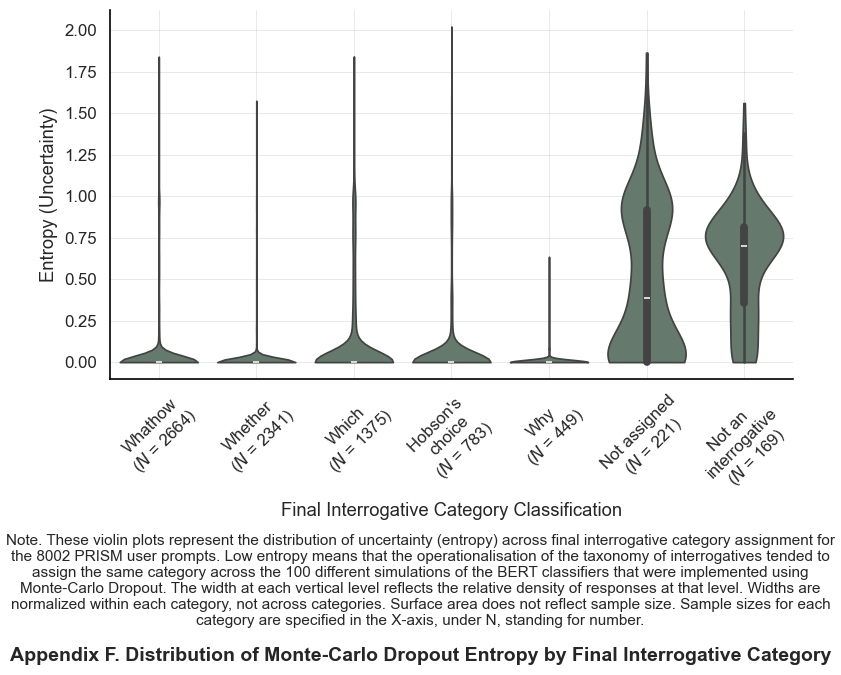

In [ ]:
###################################################################################
# Make violin plot to understand MC uncertainty distributions
##################################################################################

# (0) Set global font to Arial
mpl.rcParams['font.family'] = 'Arial'

# (1) Sort categories by descending sample size
counts = classified_df['mc_final_interrogative_category'].value_counts()
category_order = counts.sort_values(ascending=False).index.tolist()

# (2) Generate cleaned x-axis labels with formatted names and italic N
label_map = {
    'hobsons': "Hobson's \nchoice",
    'not_matched': "Not assigned",
    'M': "Not an \ninterrogative"
}

def format_label(cat):
    # Use custom label if exists, else title-case the original
    name = label_map.get(cat, cat.replace('_', ' ').title())
    return f'{name}\n($\\it{{N}}$ = {counts[cat]})'

labels = [format_label(cat) for cat in category_order]

# (3) Set Seaborn style for clean background
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# (4) Create A4-friendly figure
plt.figure(figsize=(8, 5.5))

# (5) Create violin plot
sns.violinplot(
    data=classified_df,
    x='mc_final_interrogative_category',
    y='mc_entropy',
    order=category_order,
    inner='box',
    density_norm='width', 
    cut=0,
    color='#627D6B'
)

# (6) Customize titles and axis labels
plt.figtext(
    0.5, -0.22, # make sure its below the plot and centered
    'Appendix F. Distribution of Monte-Carlo Dropout Entropy by Final Interrogative Category',
    ha='center',
    fontsize=14,
    fontweight='bold',
    fontfamily='Arial'
)

plt.xlabel('Final Interrogative Category Classification')
plt.ylabel('Entropy (Uncertainty)')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)

# (7) Set x and y axis spines to black
ax = plt.gca()
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.2)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# (8) Subtle grid styling
plt.grid(True, linestyle='-', linewidth=0.4, color='gray', alpha=0.3)

# (9) Remove legend if it exists
legend = ax.get_legend()
if legend:
    legend.remove()

# (10) Add note below the plot
plt.figtext(
    0.5, -0.15,  # adjust this for vertical placement
    "Note. These violin plots represent the distribution of uncertainty (entropy) across final interrogative category assignment for the 8002 PRISM user prompts. "
    "Low entropy means that the operationalisation of the taxonomy of interrogatives tended to assign the same category across the 100 different simulations of the BERT "
    "classifiers that were implemented using Monte-Carlo Dropout. The width at each vertical level reflects the relative density of responses at that level. Widths "
    "are normalized within each category, not across categories. Surface area does not reflect sample size. Sample sizes for each category are specified in the X-axis, under N, standing for number.",
    wrap=True,
    horizontalalignment='center',
    fontfamily='Arial', 
    fontsize=11,
    linespacing=1.18
)


# (11) Layout and display
plt.tight_layout()

# (12) Save the figure to the output folder
plt.savefig(os.path.join(appendices_path, "appendix_f.pdf"), bbox_inches='tight', dpi=300)

plt.show()

# This visualisation is promising, because it shows that overall, there are really low entropies, 
# and the different versions of the models have consistent predictions.
# Note inferences about sample size should not be made based on the surface area of colour in this context. 


### 1. (c) For each model and each class, what is the association between the proportion of the training data, and the performance of the model in that class?

In [ ]:
# (1) Rename training data columns to match rest of project X1A into label_1A
train_df.columns = [
    col.replace("X", "label_") if col.startswith("X") else col
    for col in train_df.columns
]

# (2) Compute training proportions 
train_props = []

label_cols = [col for col in train_df.columns if col.startswith("label_")]

for col in label_cols:
    classifier = col.replace("label_", "")  # e.g., "label_1A" → "1A"
    proportions = train_df[col].value_counts(normalize=True)
    for label_value, prop in proportions.items():
        train_props.append({
            "classifier": classifier,
            "label": str(label_value),
            "train_proportion": prop
        })

train_props_df = pd.DataFrame(train_props)

# (3) Merge with per_class_df 
merged_df = pd.merge(per_class_df, train_props_df, on=["classifier", "label"], how="inner")

# (4) Compute correlation per classifier 
corrs = merged_df.groupby("classifier")[["train_proportion", "f1-score"]].corr().iloc[0::2, -1].reset_index()
corrs = corrs.rename(columns={"f1-score": "classifier_correlation"}).drop(columns=["level_1"])

# (5) Merge correlations back 
final_df = pd.merge(merged_df, corrs, on="classifier", how="left")

# (6) Reorder columns 
final_df = final_df[["classifier", "label", "train_proportion", "f1-score", "classifier_correlation"]]

# 2. Evalaute the assumptions that are made during the training stage. Formalised as: 

(a) Classifier generalises well to unseen data (theoretical discussion in paper)

(b) Labels are correct (e.g., violated by noisy labelling)

(c) Classifier confidence aligns with correctness  


### 2. (b) Labels are correct (e.g., violated by noisy labelling)

In [7]:
###################################################################################
# Krippendorff's alpha: Round-2 labeller vs Gold-standard (nominal)
###################################################################################

# Map round-two classifier columns to gold_df columns
r2_to_gold = {
    "1A": "Q1A",
    "1B": "Q1B",
    "2A": "Q2A",
    "2B": "Q2B",
    "2C": "Q2C",
    "3A": "Q3A",
    "4A": "Q4A",
}

# Only keep classifiers that appear in BOTH dataframes
round2_cols = set(labeller1_round_two.columns)
gold_cols   = set(gold_df.columns)
pairs = [(r2, r2_to_gold[r2]) for r2 in r2_to_gold if (r2 in round2_cols and r2_to_gold[r2] in gold_cols)]

kripp_alpha_results = {}
counts_compared = {}

for r2_col, gold_col in pairs:
    # 1) Align on utterance_id (same items only)
    pair = (
        labeller1_round_two[["utterance_id", r2_col]]
        .merge(
            gold_df[["utterance_id", gold_col]],
            on="utterance_id",
            how="inner",
            suffixes=("_r2", "_gold")
        )
    )

    # 2) Drop rows without labels for this classifier
    pair = pair.dropna(subset=[r2_col, gold_col])
    if pair.empty:
        kripp_alpha_results[r2_col] = np.nan
        counts_compared[r2_col] = 0
        continue

    # 3) Jointly encode nominal labels so integers align across coders
    le = LabelEncoder()
    le.fit(pd.concat([pair[r2_col], pair[gold_col]], ignore_index=True))

    r2_enc   = le.transform(pair[r2_col])
    gold_enc = le.transform(pair[gold_col])

    # 4) Shape: (coders, items)
    data_matrix = np.vstack([r2_enc, gold_enc])

    # 5) Krippendorff's alpha (nominal)
    alpha = krippendorff.alpha(reliability_data=data_matrix, level_of_measurement="nominal")

    kripp_alpha_results[r2_col] = alpha
    counts_compared[r2_col] = len(pair)

# Report
if not pairs:
    print("No overlapping classifiers between round-two labels and gold_df.")
else:
    print("Compared classifiers (round2 → gold):", pairs)
    for clf in [p[0] for p in pairs]:
        n = counts_compared.get(clf, 0)
        a = kripp_alpha_results.get(clf, np.nan)
        print(f"{clf}: α = {a:.3f}  (n={n} items)")


Compared classifiers (round2 → gold): [('1A', 'Q1A'), ('2B', 'Q2B'), ('4A', 'Q4A')]
1A: α = 0.709  (n=80 items)
2B: α = 0.691  (n=80 items)
4A: α = 0.695  (n=80 items)


### 2. (c) Classifier confidence aligns with correctness  
> While these cannot be directly interpreted as probabilities, if there is a lower softmaxed output, this means that the model's confidence is shared with other outputs. 

In [8]:
###################################################################################
# Compute expected calibration error
# #################################################################################

# (1) Filter classified_df to only gold utterances 
gold_utterance_ids = gold_df["utterance_id"]
classified_gold_df = classified_df[classified_df["utterance_id"].isin(gold_utterance_ids)]

# (2) Align so both have the same order 
merged_df = pd.merge(
    gold_df,
    classified_gold_df,
    on="utterance_id",
    suffixes=("_gold", "_pred")
)

# (3) Define mapping between gold and predicted columns 
clf_pairs = [
    ("Q1A", "score_1A"),
    ("Q1B", "score_1B"),
    ("Q2A", "score_2A"),
    ("Q2B", "score_2B"),
    ("Q2C", "score_2C"),
    ("Q3A", "score_3A"),
    ("Q4A", "score_4A")
]

# (4) Compute ece for each classifier using sourced function
ece_results = {}
for gold_col, prob_col in clf_pairs:
    y_true = merged_df[gold_col].values
    y_prob = merged_df[prob_col].values
    ece_results[gold_col] = compute_ece(y_true, y_prob, n_bins=10)

ece_results_df = pd.DataFrame.from_dict(ece_results, orient="index", columns=["ECE"])
print(ece_results_df)

          ECE
Q1A  0.964129
Q1B  0.982343
Q2A  0.967949
Q2B  0.939222
Q2C  0.931529
Q3A  0.993611
Q4A  0.946563


# 3. Evaluate assumptions that are made during the inference stage. 
- See discussion on the implementation of the DSL estimator (Egami et al., 2024) in the report. 